In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, pipeline
from sklearn.preprocessing import OneHotEncoder
from datasets import load_dataset

In [14]:
train = pd.read_csv('data/train.csv')

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
df = pd.read_csv('data/train.csv')

# Step 2: Define the label column
label_column = 'discourse_effectiveness'  # Replace with your actual label column name

# Optional: Inspect class distribution
print("Original Dataset Class Distribution:")
print(df[label_column].value_counts(normalize=True))

# Step 3: First split - Train and Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,  # 20% to temp
    random_state=42,
    stratify=df[label_column]
)

# Step 4: Second split - Validation and Test
validation_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # 10% each
    random_state=42,
    stratify=temp_df[label_column]
)

# Step 5: Save the splits to CSV files
train_df.to_csv('train.csv', index=False)
validation_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Step 6: Verify the splits
print("\nTraining Set Class Distribution:")
print(train_df[label_column].value_counts(normalize=True))

print("\nValidation Set Class Distribution:")
print(validation_df[label_column].value_counts(normalize=True))

print("\nTest Set Class Distribution:")
print(test_df[label_column].value_counts(normalize=True))

print("\nData successfully split and saved to CSV files.")


Original Dataset Class Distribution:
discourse_effectiveness
Adequate       0.570570
Effective      0.253665
Ineffective    0.175765
Name: proportion, dtype: float64

Training Set Class Distribution:
discourse_effectiveness
Adequate       0.570549
Effective      0.253672
Ineffective    0.175779
Name: proportion, dtype: float64

Validation Set Class Distribution:
discourse_effectiveness
Adequate       0.570729
Effective      0.253536
Ineffective    0.175734
Name: proportion, dtype: float64

Test Set Class Distribution:
discourse_effectiveness
Adequate       0.570574
Effective      0.253739
Ineffective    0.175687
Name: proportion, dtype: float64

Data successfully split and saved to CSV files.


In [16]:
dataset = load_dataset('csv', data_files={'train': 'train.csv',
                                         'validation': 'validation.csv',
                                         'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [17]:
label_mapping = {
    "Effective": 0,
    "Adequate": 1,
    "Ineffective": 2
}

def encode_labels(example):
    example['labels'] = label_mapping[example['discourse_effectiveness']]
    return example

dataset = dataset.map(encode_labels)

Map:   0%|          | 0/29412 [00:00<?, ? examples/s]

Map:   0%|          | 0/3676 [00:00<?, ? examples/s]

Map:   0%|          | 0/3677 [00:00<?, ? examples/s]

In [18]:
model_name = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [19]:
def tokenize_function(example):
    return tokenizer(example['discourse_text'], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/29412 [00:00<?, ? examples/s]

Map:   0%|          | 0/3676 [00:00<?, ? examples/s]

Map:   0%|          | 0/3677 [00:00<?, ? examples/s]

In [20]:
tokenized_datasets = tokenized_datasets.remove_columns(['discourse_id', 'essay_id', 'discourse_text', 'discourse_effectiveness'])  # Remove unnecessary columns
tokenized_datasets.set_format('torch')

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_datasets['validation'], batch_size=16)

In [22]:
from transformers import AutoModelForSequenceClassification

num_labels = 3  # Effective, Adequate, Not Effective
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer.train()

  0%|          | 0/7356 [00:00<?, ?it/s]

{'loss': 0.8322, 'grad_norm': 5.994781017303467, 'learning_rate': 1.864056552474171e-05, 'epoch': 0.27}
{'loss': 0.7786, 'grad_norm': 3.134608268737793, 'learning_rate': 1.728113104948342e-05, 'epoch': 0.54}
{'loss': 0.7565, 'grad_norm': 3.920692205429077, 'learning_rate': 1.5921696574225122e-05, 'epoch': 0.82}


  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 0.7365413308143616, 'eval_accuracy': 0.6673014145810664, 'eval_precision': 0.6849732894552873, 'eval_recall': 0.6673014145810664, 'eval_f1': 0.6212415376216386, 'eval_runtime': 28.4389, 'eval_samples_per_second': 129.259, 'eval_steps_per_second': 8.088, 'epoch': 1.0}
{'loss': 0.7225, 'grad_norm': 5.27198600769043, 'learning_rate': 1.456226209896683e-05, 'epoch': 1.09}
{'loss': 0.6509, 'grad_norm': 7.424563407897949, 'learning_rate': 1.3202827623708539e-05, 'epoch': 1.36}
{'loss': 0.6555, 'grad_norm': 3.2625443935394287, 'learning_rate': 1.1843393148450246e-05, 'epoch': 1.63}
{'loss': 0.6474, 'grad_norm': 7.548019886016846, 'learning_rate': 1.0483958673191954e-05, 'epoch': 1.9}


  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 0.740373969078064, 'eval_accuracy': 0.6811751904243744, 'eval_precision': 0.6816488827890452, 'eval_recall': 0.6811751904243744, 'eval_f1': 0.6508559060803725, 'eval_runtime': 28.2667, 'eval_samples_per_second': 130.047, 'eval_steps_per_second': 8.137, 'epoch': 2.0}
{'loss': 0.545, 'grad_norm': 9.529881477355957, 'learning_rate': 9.12452419793366e-06, 'epoch': 2.18}
{'loss': 0.5104, 'grad_norm': 10.667677879333496, 'learning_rate': 7.765089722675368e-06, 'epoch': 2.45}
{'loss': 0.5058, 'grad_norm': 6.845552444458008, 'learning_rate': 6.405655247417075e-06, 'epoch': 2.72}
{'loss': 0.5123, 'grad_norm': 10.714924812316895, 'learning_rate': 5.046220772158782e-06, 'epoch': 2.99}


  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 0.8620838522911072, 'eval_accuracy': 0.6531556039173014, 'eval_precision': 0.6508464232444426, 'eval_recall': 0.6531556039173014, 'eval_f1': 0.6422086445858991, 'eval_runtime': 28.3151, 'eval_samples_per_second': 129.825, 'eval_steps_per_second': 8.123, 'epoch': 3.0}
{'loss': 0.3933, 'grad_norm': 10.01401138305664, 'learning_rate': 3.68678629690049e-06, 'epoch': 3.26}
{'loss': 0.3705, 'grad_norm': 19.744951248168945, 'learning_rate': 2.327351821642197e-06, 'epoch': 3.53}
{'loss': 0.3764, 'grad_norm': 15.006087303161621, 'learning_rate': 9.679173463839045e-07, 'epoch': 3.81}


  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 0.9921711683273315, 'eval_accuracy': 0.6640369967355821, 'eval_precision': 0.6574140547230408, 'eval_recall': 0.6640369967355821, 'eval_f1': 0.6496207408279846, 'eval_runtime': 28.2886, 'eval_samples_per_second': 129.946, 'eval_steps_per_second': 8.13, 'epoch': 4.0}
{'train_runtime': 3557.1796, 'train_samples_per_second': 33.073, 'train_steps_per_second': 2.068, 'train_loss': 0.5797724244126553, 'epoch': 4.0}


TrainOutput(global_step=7356, training_loss=0.5797724244126553, metrics={'train_runtime': 3557.1796, 'train_samples_per_second': 33.073, 'train_steps_per_second': 2.068, 'total_flos': 7738691842215936.0, 'train_loss': 0.5797724244126553, 'epoch': 4.0})

In [25]:
results = trainer.evaluate(tokenized_datasets['test'])
print(results)

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 0.971185028553009, 'eval_accuracy': 0.6701115039434321, 'eval_precision': 0.661356630554658, 'eval_recall': 0.6701115039434321, 'eval_f1': 0.6570066457220365, 'eval_runtime': 28.2643, 'eval_samples_per_second': 130.093, 'eval_steps_per_second': 8.137, 'epoch': 4.0}


  0%|          | 0/230 [00:00<?, ?it/s]

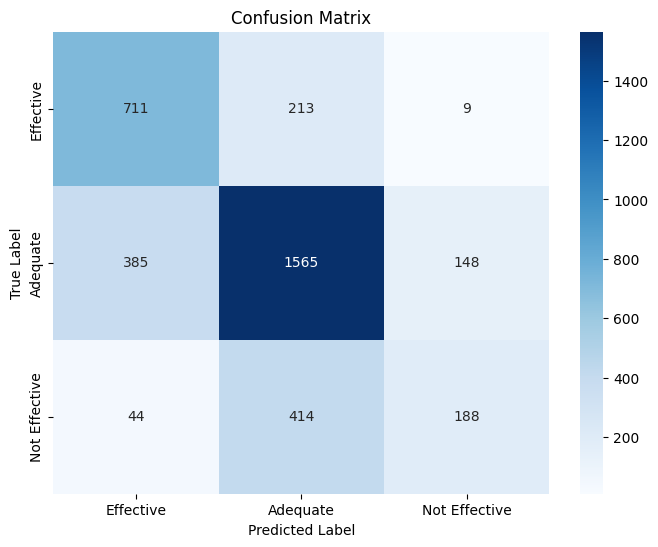

Classification Report:

               precision    recall  f1-score   support

    Effective       0.71      0.75      0.73      2098
     Adequate       0.62      0.76      0.69       933
Not Effective       0.54      0.29      0.38       646

     accuracy                           0.67      3677
    macro avg       0.63      0.60      0.60      3677
 weighted avg       0.66      0.67      0.66      3677



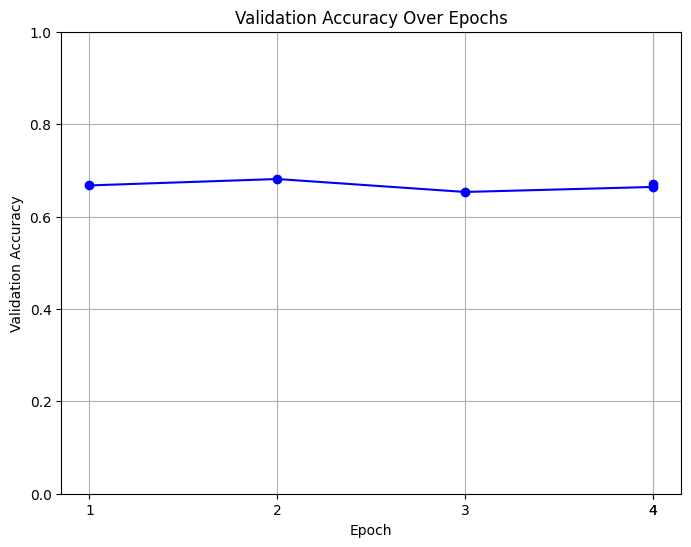

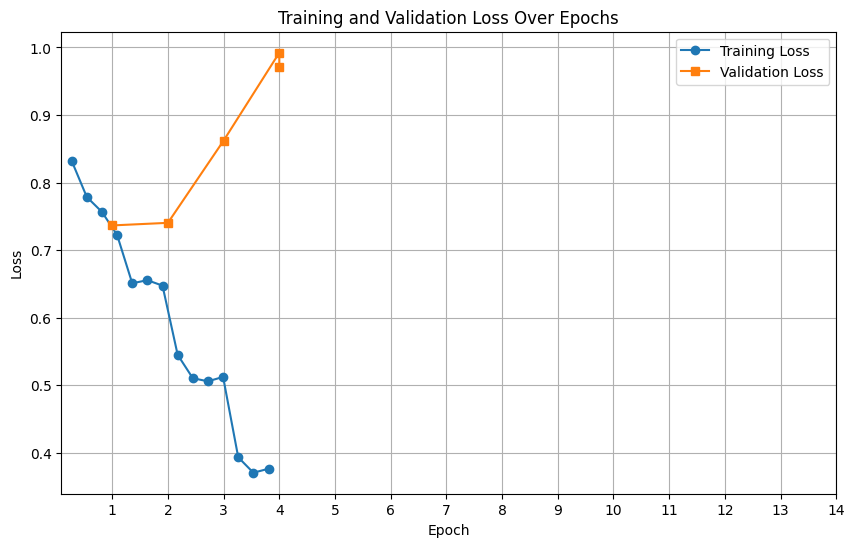

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Generate Predictions on Test Set
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 2. Define Label Mapping
id_to_label = {0: "Effective", 1: "Adequate", 2: "Not Effective"}
predicted_labels_str = [id_to_label[label] for label in predicted_labels]
true_labels_str = [id_to_label[label] for label in true_labels]

# 3. Create Confusion Matrix
cm = confusion_matrix(true_labels_str, predicted_labels_str, labels=["Effective", "Adequate", "Not Effective"])

# 4. Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Effective", "Adequate", "Not Effective"], 
            yticklabels=["Effective", "Adequate", "Not Effective"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Print Classification Report
print("Classification Report:\n")
print(classification_report(true_labels_str, predicted_labels_str, target_names=["Effective", "Adequate", "Not Effective"]))

# 6. Plot Accuracy Over Epochs
log_history = trainer.state.log_history
epochs = []
accuracies = []

for log in log_history:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xticks(epochs)
plt.ylim(0,1)
plt.grid(True)
plt.show()

# 7. (Optional) Plot Loss Over Epochs
train_losses = []
eval_losses = []
epochs_loss = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_losses.append(log['loss'])
        epochs_loss.append(log['epoch'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10,6))
plt.plot(epochs_loss, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, eval_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xticks(range(1, len(epochs_loss)+1))
plt.legend()
plt.grid(True)
plt.show()